'''Sayantan Mukhopadhyay (sm9752)'''

In [ ]:
import numpy as np
import os
from os import path
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.image import imread

Function to calculate the Gray level of a Pixel

In [ ]:
def calc_gray(i):
  
  g = round(i[0] * 0.299 + i[1] * 0.587 + i[2] * 0.114)     # Using given formula for grayscale conversion
  return g

Function to read the Image and construct the Normalized Gray level Histogram of the Image

In [ ]:
def histogramify(image):
  
  img = imread(image)
  im = np.apply_along_axis(calc_gray, 2, img)
  g = im.flatten()
  h = y = np.zeros(256)     # Initializing the histogram with 0s
  for i in g:
    h[i] += 1
  n = np.sum(h)
  h = h / n
  return h, im

Function to calculate the Weight within a section of the Gray level Histogram

$ω(i, j)=\sum_{x=i}^j \ {H(x)}$

In [ ]:
def weights(hist, start, end):
  
  wt = 0
  for i in range(start, end + 1):
    wt += hist[i]
  return wt

Function to calculate the Mean within a section of the Gray level Histogram

$µ(i, j)=\sum_{x=i}^j \frac {x H(x)}{ω(i,j)}$

In [ ]:
def means(hist, start, end):
  
  mn = 0
  wt = weights(hist, start, end)
  for i in range(start, end + 1):
    mn += (i * hist[i])
  if wt == 0:
    wt = + 2.2250738585072014e-308        # adding the smallest positive value possible to prevent Divide by Zero
  mn /= wt 
  return mn


Function to calculate the Mean within a section of the Gray level Histogram

$σ^2(i,j)=\sum_{x=i}^j[x-µ(i,j)]^2 \frac {H(x)}{ω(i,j)}$

In [ ]:
def variances(hist, start, end):

  vr = 0
  wt = weights(hist, start, end)
  mn = means(hist, start, end)
  for i in range(start, end):
    vr += ((i - mn) ** 2) * hist[i]
  if wt == 0:
    wt = + 2.2250738585072014e-308      # adding the smallest positive value possible to prevent Divide by Zero
  mn /= wt 
  vr /= wt
  return vr 

Finding the optimal Thresholds for the Gray level Histogram

$σ^2_w(i,j,k)=ω_1(0,i)σ^2_1(0,i)+ω_2(i,j)σ^2_2(i,j)+ω_3(j,k)σ^2_3(j,k)+ω_4(k,255)σ^2_4(k,255)$ 

In [ ]:
def thresholds(hist):

    mins1 = []
    mins2 = []
    mins3 = []
    
    # For images with 2 regions
    for i in range (0, 255):
      sm = weights(hist, 0, i) * variances(hist, 0, i) + weights(hist, i + 1, 255) * variances(hist, i + 1, 255)      # Calculating weighted variance 
      mins1.append([sm, i])
    minmin1 = min(mins1)

    # For images with 3 regions
    for i in range (0, 254):
      wi = weights(hist, 0, i)
      vi = variances(hist, 0, i)
      for j in range (i + 1, 255):
        sm = wi * vi + weights(hist, i + 1, j) * variances(hist, i + 1, j) + weights(hist, j + 1, 255) * variances(hist, j + 1, 255)      # Calculating weighted variance
        mins2.append([sm, i, j])
    minmin2 = min(mins2)

    if ((minmin1[0] <= minmin2[0]) or ((minmin1[0] - minmin2[0]) <= 200)):      # If the weighted variance for 2 regions is lesser than 3 regions
      return min(mins1)     # or the difference between weighted variance of 3 regions and 2 regions is less than 200, then the image has 2 regions
    
    else:
      # For images with 4 regions
      for i in range (1, 253):
        wi = weights(hist, 0, i)
        vi = variances(hist, 0, i)
        for j in range (i + 1, 254):
          wj = weights(hist, i + 1, j)
          vj = variances(hist, i + 1, j)
          for k in range (j + 1, 255):
            sm = wi * vi + wj * vj + weights(hist, j + 1, k) * variances(hist, j + 1, k) + weights(hist, k + 1, 255) * variances(hist, k + 1, 255)      # Calculating weighted variance
            mins3.append([sm, i, j, k])
      minmin3 = min(mins3)
      
      if ((minmin2[0] <= minmin3[0]) or ((minmin2[0] - minmin3[0]) <= 200)):  # If the weighted variance for 3 regions is lesser than 4 & 2 regions
        return min(mins2)     # or the difference between weighted variance of 4 regions and 3 regions is less than 200, then the image has 3 regions 
      else:
        return min(mins3)     # Else the image has 4 regions

Assigning 'viridis' colormap values for individual regions

In [ ]:
def segment(img, thlds):
    
    row, col = img.shape 
    y = np.zeros((row, col))

    # For images with 2 regions
    if len(thlds) == 1:
      for i in range(0,row):
        for j in range(0,col):
          if img[i,j] <= thlds[0]:
            y[i,j] = 0      # 0 for 1st region
          else:
            y[i,j] = 255      # 255 for 2nd region

    # For images with 3 regions
    elif len(thlds) == 2:
      for i in range(0,row):
        for j in range(0,col):
          if img[i,j] <= thlds[0]:
            y[i,j] = 0      # 0 for 1st region
          elif img[i,j] > thlds[0] and img[i,j] <= thlds[1]:
            y[i,j] = 128      # 128 for 2nd region
          else:
            y[i,j] = 255      # 255 for 3rd region

    # For images with 4 regions
    elif len(thlds) == 3:
      for i in range(0,row):
        for j in range(0,col):
          if img[i,j] <= thlds[0]:
            y[i,j] = 0      # 0 for 1st region
          elif img[i,j] > thlds[0] and img[i,j] <= thlds[1]:
            y[i,j] = 85     # 85 for 2nd region
          elif img[i,j] >= thlds[1] and img[i,j] <= thlds[2]:
            y[i,j] = 171      # 171 for 3rd region
          else:
            y[i,j] = 255      # 255 for 4th region
    return y

Reconstructing the image and saving the BMP file

In [ ]:
def redraw(image_name, img, mint):
  plt.axis('off')
  plt.imshow(segment(img, mint))
  plt.savefig('temp' + image_name + '.png', bbox_inches='tight', pad_inches=0)      # Saving a temporary PNG file
  Image.open('temp' + image_name + '.png').resize((img.shape[1], img.shape[0]), Image.LANCZOS).save(image_name + '-out.bmp','BMP')      # Saving the BMP file
  os.remove('temp' + image_name + '.png')     # Removing the temporary PNG file

Main Function to call other functions

In [ ]:
def otsu(image):
  
  image_name = path.splitext(image)[0]      # Getting file name
  hist, img = histogramify(image)
  mint = thresholds(hist)
  mint.pop(0)     # Removing the first element of this list (weighted variance)
  print("Number of Regions:", len(mint) + 1)
  print("Thresholds:", mint)
  redraw(image_name, img, mint)

Basket Balls

Number of Regions: 3
Thresholds: [107, 196]


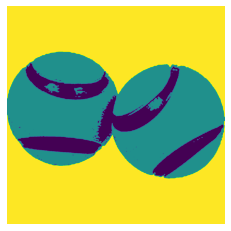

In [ ]:
otsu('basket_balls.bmp')

Black Balls

Number of Regions: 2
Thresholds: [142]


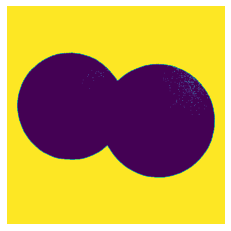

In [ ]:
otsu('blackroll-duoball.bmp')

Data 13

Number of Regions: 3
Thresholds: [121, 210]


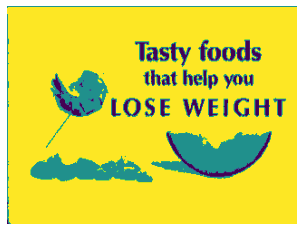

In [ ]:
otsu('data13.bmp')

Tiger

Number of Regions: 4
Thresholds: [48, 110, 178]


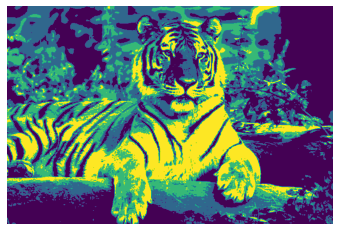

In [ ]:
otsu('tiger1.bmp')

Rock Stream

Number of Regions: 4
Thresholds: [53, 104, 166]


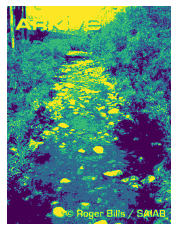

In [ ]:
otsu('rock-stream1.bmp')